# Generator's hyperparameters tuning

In [96]:
import sys

from grail_metabolism.model.generator import Generator

sys.path.append('..')
from grail_metabolism.utils.optuna import OptunaWrapper
from grail_metabolism.utils.preparation import MolFrame, rules

In [2]:
tune = OptunaWrapper()

### val_frame

Here we will only optimize huber loss value on the validation set

In [4]:
val_triples = MolFrame.read_triples('../grail_metabolism/data/val_triples.txt')
val_frame = MolFrame.from_file('../grail_metabolism/data/val.sdf', val_triples, standartize=False)

Processing reactions:   0%|          | 0/1061 [00:00<?, ?it/s]

In [99]:
import pickle as pkl

In [ ]:
with open('../grail_metabolism/data/train.pkl', 'rb') as f:
    train_frame = pkl.load(f)

In [5]:
with open('../grail_metabolism/data/smirks.txt') as f:
    rules = f.read().splitlines()

### val_frame setup

In [ ]:
val_frame.negatives()
val_frame.morganize()
val_frame.singlegraphs()
val_frame.label_reactions(rules)

In [7]:
from grail_metabolism.utils.transform import from_rule
from tqdm.auto import tqdm

In [8]:
rule_dict = {rule: from_rule(rule) for rule in tqdm(rules)}

  0%|          | 0/474 [00:00<?, ?it/s]

In [18]:
val_frame.reaction_labels['CN(C)N=O'] = [0] * 474

### make study

In [ ]:
tune.make_study(val_frame, val_frame, 'generator', rule_dict=rule_dict)

In [34]:
from optuna.visualization.matplotlib import plot_optimization_history

<Axes: title={'center': 'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

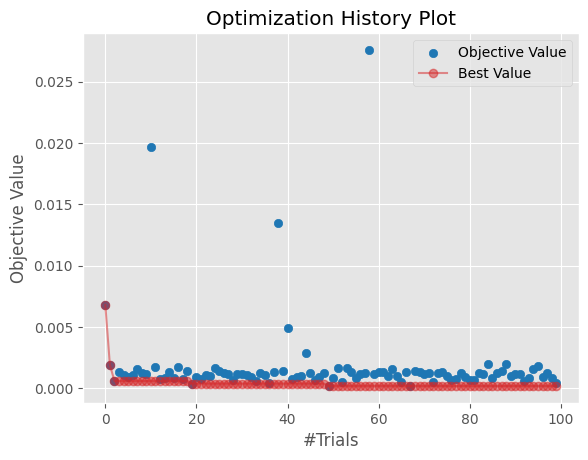

In [36]:
plot_optimization_history(tune.study)

In [ ]:
!pip install optuna_fast_fanova

In [76]:
import optuna
from optuna_fast_fanova import FanovaImportanceEvaluator

importance = optuna.importance.get_param_importances(
        tune.study, evaluator=FanovaImportanceEvaluator()
    )

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
tune.study.best_params

{'lr': 0.00029146730322139635,
 'decay': 8.063519478493035e-05,
 'x1': 785,
 'x2': 519}

<Axes: >

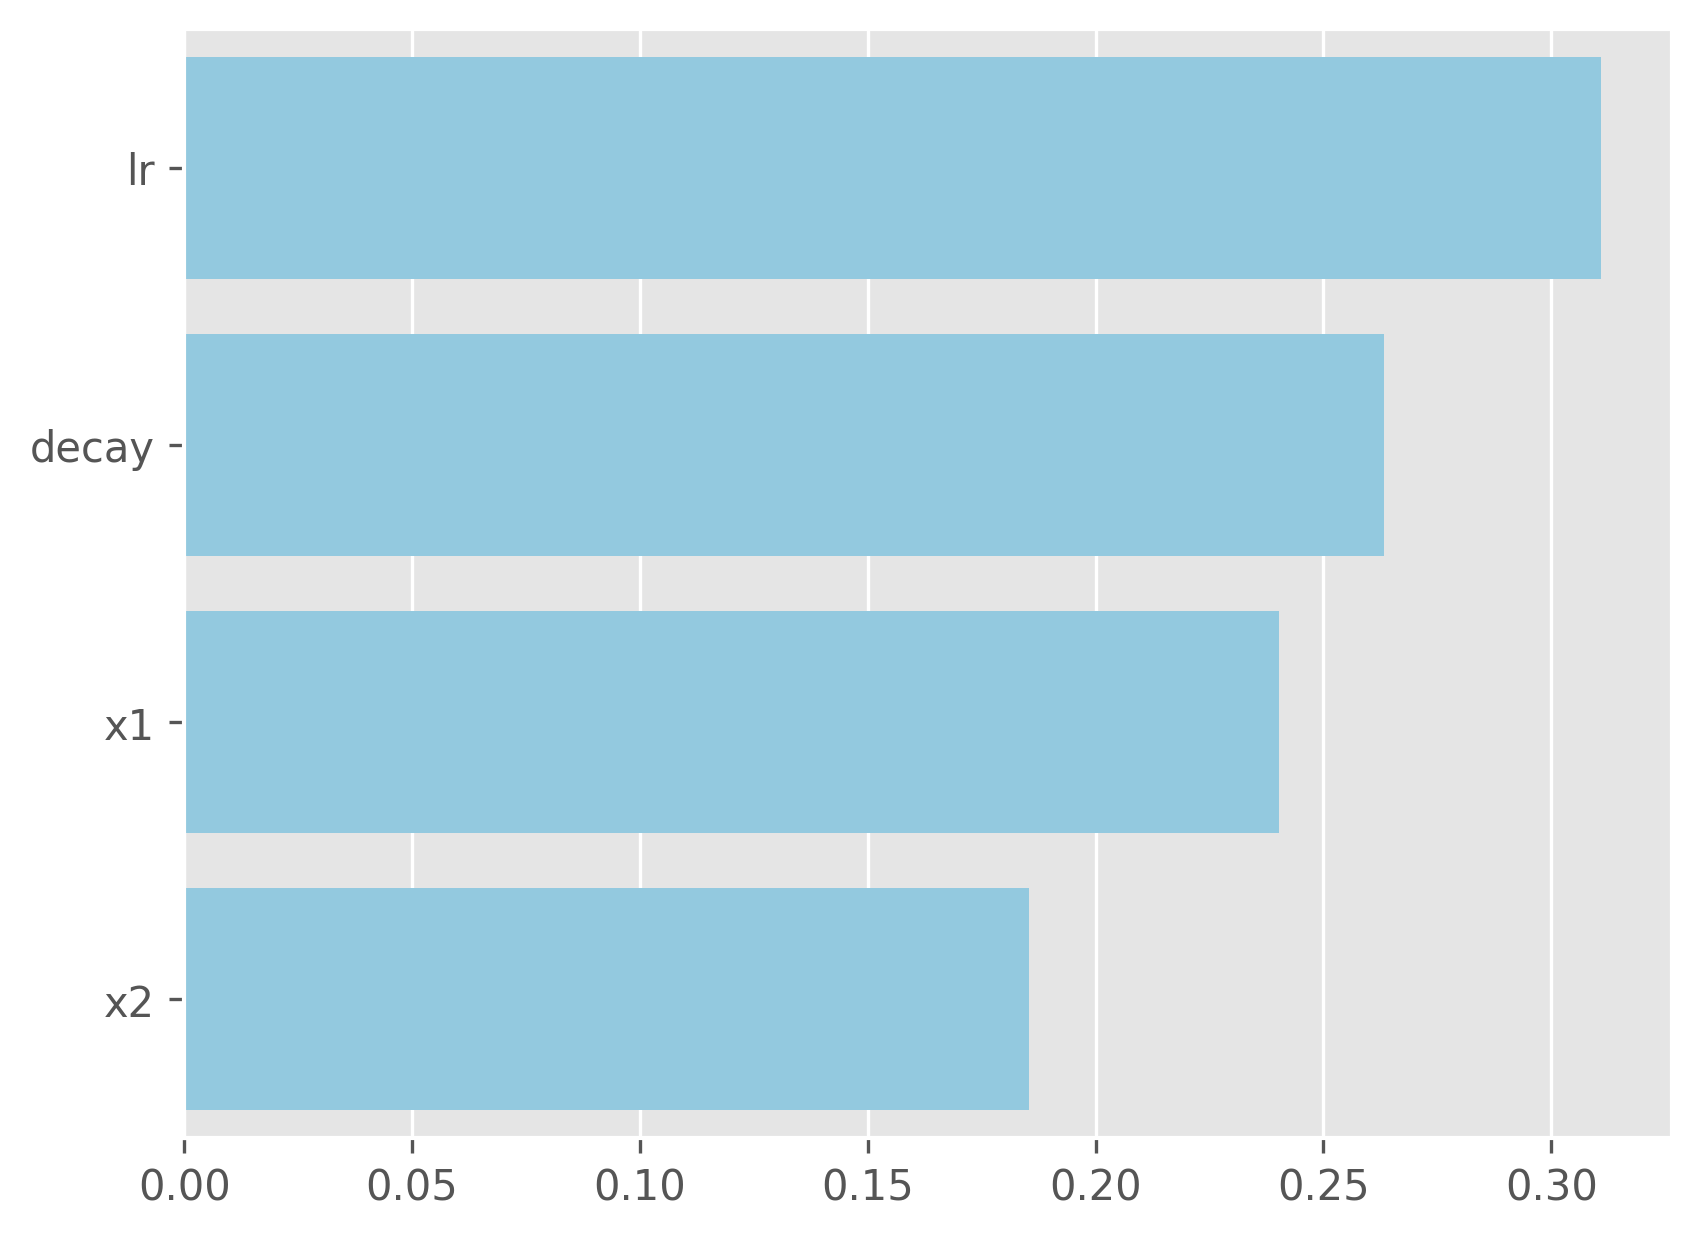

In [92]:
plt.figure(dpi=300)
sns.barplot(
    importance, orient='h', color='skyblue', label='importance'
)

In [98]:
gen = Generator(rule_dict, 10, 6, arg_vec=[785, 519])

In [ ]:
gen.fit(train_frame)

In [67]:
st_single = OptunaWrapper.from_pickle('../notebooks/study_single.pkl')

In [93]:
importance = optuna.importance.get_param_importances(
        st_single.study, evaluator=FanovaImportanceEvaluator()
    )

<Axes: >

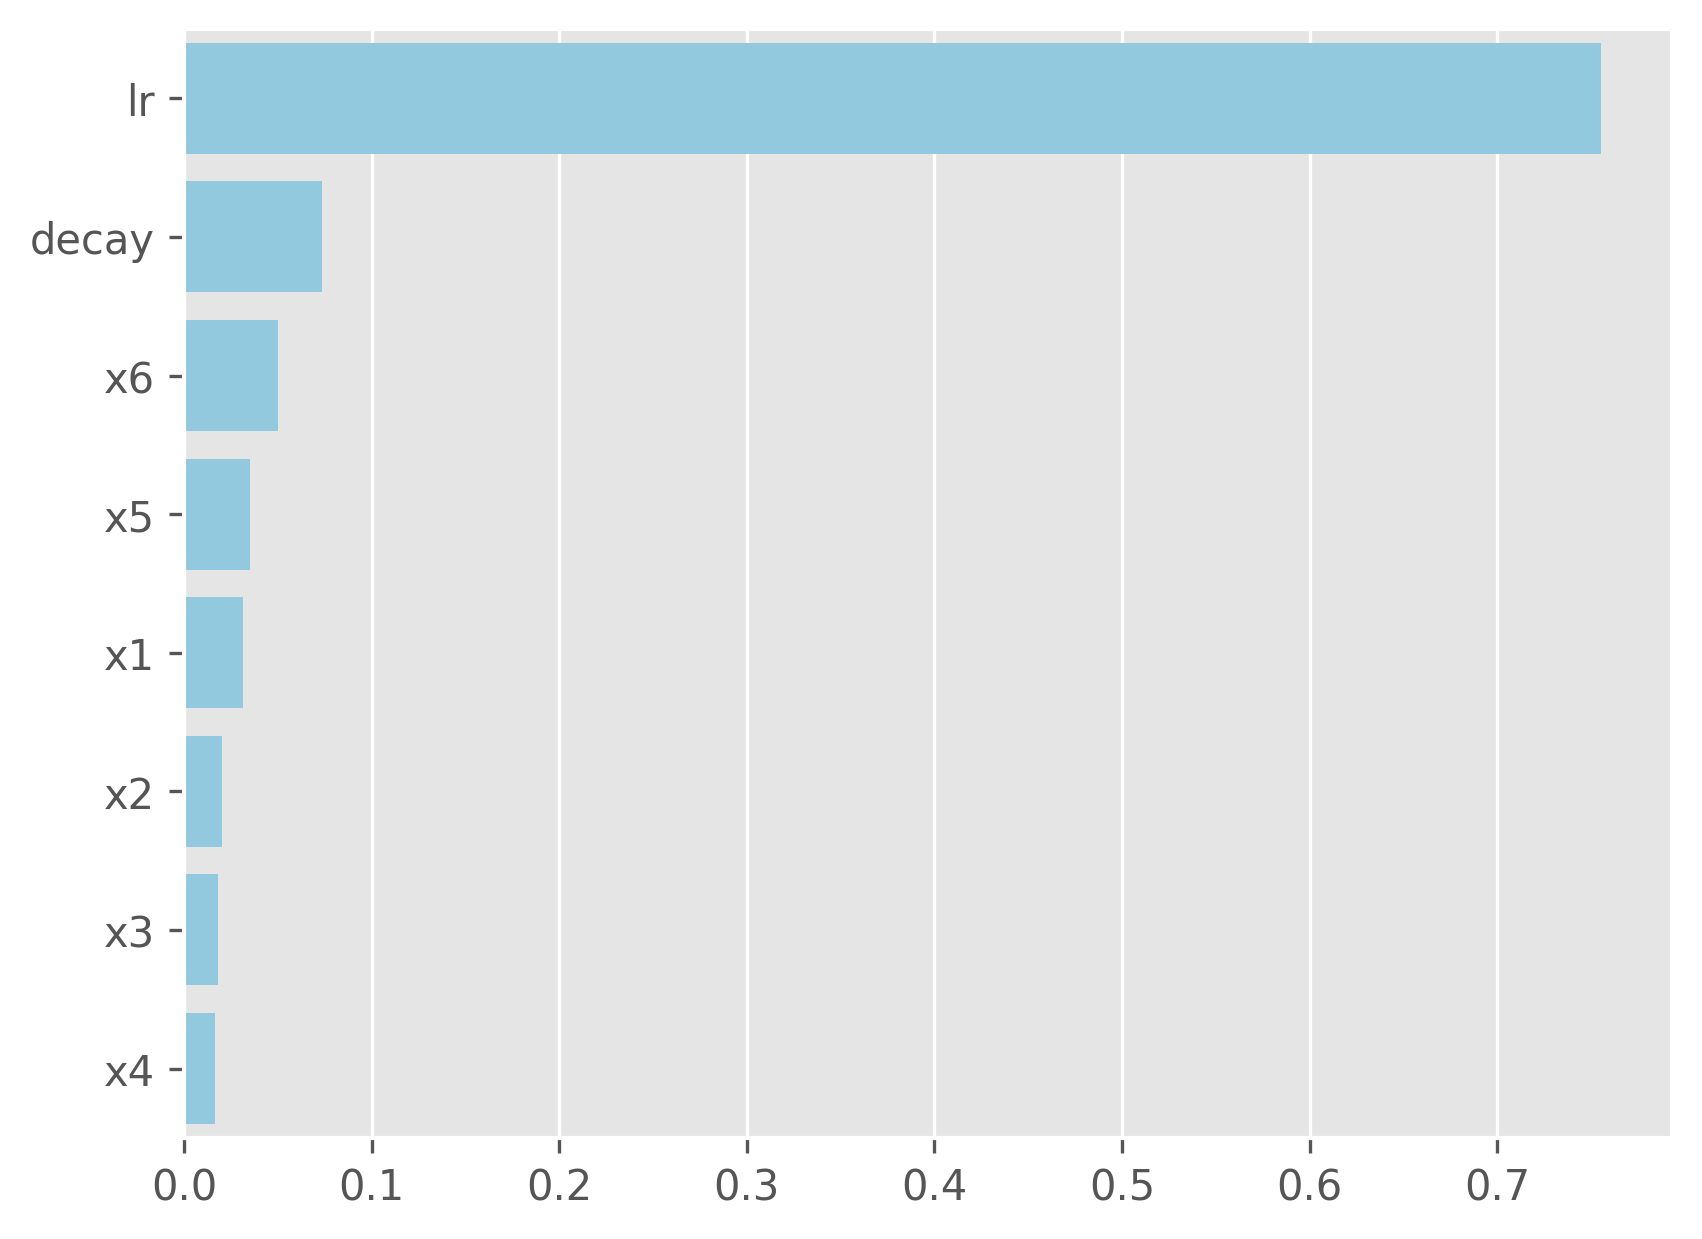

In [94]:
plt.figure(dpi=300)
sns.barplot(
    importance, orient='h', color='skyblue',
)

In [87]:
st_single.mode = 'single'
st_single.create_optimal_filter()

In [90]:
print(st_single.study.best_params)

{'lr': 0.00017084628961269979, 'decay': 8.204942593495107e-05, 'x1': 191, 'x2': 510, 'x3': 507, 'x4': 665, 'x5': 941, 'x6': 789}
